# Reproduce Seq2Vec embedding

https://www.tensorflow.org/tutorials/text/word2vec

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/skipgrams

In [2]:
import os
import numpy as np
import pandas as pd
import json
import shutil
import tensorflow as tf

from pathlib import Path
from pprint import pprint
from tqdm.notebook import trange, tqdm
from tqdm.keras import TqdmCallback

from tensorflow.keras import Sequential, Model, Input, layers
from tensorflow.keras.preprocessing.sequence import pad_sequences, skipgrams
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
proc_data = Path('../data/virtifier').resolve()
seq2vec_repo = Path('../repos/seq2vec').resolve()
assert proc_data.is_dir()
assert seq2vec_repo.is_dir()

# Preprocessing from Seq2Vec code


Seq2Vec dcode provides the following code to preprocess nucleotide sequence into sequence of codons for embeddings:

```python
f=open('your_data.fasta','r')
g=open('preprocssed_data.fasta','a') 
lines=f.readlines()
contex=3 
for line in lines:
    l=len(line)-1
    for i in range(0,(l-contex+1)):
        a=line[i:i+contex]
        x=str(a).replace("AAA","1").replace("TTT","2").replace("GAA","3").replace("AAG","4").replace("AAT","5").replace("ATT","6").replace("CAA","7").replace("TGA","8").replace("TTC","9").replace("AGA","10").replace("GAT","11").replace("AAC","12").replace("TAA","13").replace("TTA","14").replace("TCA","15").replace("TAT","16").replace("ATG","17").replace("TGG","18").replace("ATC","19").replace("TTG","20").replace("ATA","21").replace("GTT","22").replace("CTG","23").replace("CTT","24").replace("ACA","25").replace("CAG","26").replace("CGA","27").replace("GGT","28").replace("GGC","29").replace("GCA","30").replace("CAT","31").replace("GCG","32").replace("CGC","33").replace("GCT","34").replace("TCT","35").replace("TCG","36").replace("ACC","37").replace("AGC","38").replace("CGG","39").replace("GAC","40").replace("CCG","41").replace("CCA","42").replace("TGC","43").replace("ACG","44").replace("GGA","45").replace("TGT","46").replace("ACT","47").replace("TAC","48").replace("AGT","49").replace("GCC","50").replace("GAG","51").replace("GTA","52").replace("GTG","53").replace("AGG","54").replace("CGT","55").replace("CAC","56").replace("GTC","57").replace("TCC","58").replace("CCT","59").replace("CTC","60").replace("CTA","61").replace("GGG","62").replace("TAG","63").replace("CCC","64").replace(",\n","\n")
        if i<(1-contex+1):
            g.write(str(x)+",")
        else:
            g.write(str(x))
    g.write("\n")
f.close()
g.close()
```

It corresponds to the explanation in the paper:

> Before embedding, a [nucleotide](https://www.ncbi.nlm.nih.gov/Class/MLACourse/Original8Hour/Genetics/nucleotide.html) sequence is preprocessed into a string of **codons** with a *stride* of some bases. As an example, take a look at the nucleotide sequence **`AATGCAGTCCAT`**.
> 
> It is first converted into the format of a **codon sentence** **`AAT, ATG, TGC, GCA, CAG, AGT, GTC, TCC, CCA, CAT`** with a stride of **one base**, where each codon can be regarded as a word in a sentence. 
>
> The **list of all 64 unique codons** composes a complete codon dictionary as **[‘AAA’,‘AAT’, ‘AAG’, ‘AAC’, ‘ATA’, ‘ATT’, . . .]**, which is used for codon embedding the latter. 

The codon encoding used by Seq2Vec is stored in `codon2codes.json`, for easier handling. Using this, the preprocessing code can be rewritten as:

In [5]:
p2codon_codes = proc_data / 'seq2vec_codon2codes.json'
with open(p2codon_codes, 'r') as fp:
    codon2codes = json.load(fp)
code2codons = {i:c for c, i in codon2codes.items()}

In [7]:
def preprocess_fasta(fasta_path, window=3, mode='both'):
    """Preprocess sequence from fasta file into a sequence of codons, with window size
    
    Return:
        sequences as a list of encoded sequences
    """
    # Validate parameters
    if mode not in ['encoded', 'literal', 'both']:
        raise ValueError(f"mode should be either 'literal' or 'encoded', not '{mode}'")

    if isinstance(fasta_path, str):
        fasta_path = Path(fasta_path)
    elif not isinstance(fasta_path, Path):
        raise TypeError(f"fasta_path must be a string or a Path, not {fasta_path}: {type(fasta_path)}")

    sequences_literal = []
    sequences_encoded = []
    with open(fasta_path, 'r') as fp:
        line_nbr = 0
        # Read fasta file line by line
        while True:
            line = fp.readline()
            # EOF
            if line == '':
                break
            # # Early Exit
            # elif line_nbr > 10:
            #     break
            # Fasta Comment Line
            elif line.startswith('>'):
                continue
            # Fasta Sequence Line
            else:
                line_nbr += 1
                sequence_literal = []
                sequence_encoded = []
                line_lentgh = len(line) - 1
                for i in range(0, line_lentgh-window+1):
                # for i in range(0, 5):
                    codon_literal = line[i:i+window]
                    codon_encoded = codon2codes[codon_literal]
                    sequence_literal.append(codon_literal)
                    sequence_encoded.append(codon_encoded)
                sequences_literal.append(sequence_literal)
                sequences_encoded.append(sequence_encoded)
        if mode == 'literal':
            return sequences_literal
        elif mode == 'encoded':
            return sequences_encoded
        elif mode == 'both':
            return sequences_literal, sequences_encoded
        else:
            pass

p2fasta = proc_data / 'training_sequences_300bp.fasta'

sequences, encoded = preprocess_fasta(p2fasta, mode='both')
len(sequences)

9000

In [8]:
print(sequences[0][:10])
print(encoded[0][:10])

['TGT', 'GTC', 'TCT', 'CTA', 'TAT', 'ATT', 'TTC', 'TCT', 'CTA', 'TAT']
[46, 57, 35, 61, 16, 6, 9, 35, 61, 16]


# Skip-gram

**Skip-gram** models are used in natural language processing to create word embeddings by training the model to predict the **context** (or neighbors) of a **target word**, given a specific *corpus* (in NLP, a corpus is the set of text/documents that represents the domain where the work is done). 

The model is trained on skip-grams, i.e. *n-grams* (sets of n words) describing the context, based on a specific window. 

The context of a word can be represented through a set of skip-gram pairs of (target_word, context_word) where *context_word* appears in the neighboring context of *target_word*. Context is defined by a window.

In the example below, we use 2-grams and a window of 2 as well. 

<img src="img/ref.01_word2vec_skipgram.png" width=600>


Given a vocabulary of $W$ words, the Skip-gram model will predict 
$$P = f(w_{target})$$

The the skip-gram model is a classification problem with $W$ classes and we want to predict $P$, a vector with $W$ dimensions: 
$$ P_i = P(w_i \text{ is a context word} | w_{target}) \quad \text{ for } \small 1 \le i\le W $$

The *training objective* of the skip-gram model is to maximize the likelihood of predicting **context words** given the **target word**. 


For a sequence of words *w<sub>1</sub>, w<sub>2</sub>, ... w<sub>T</sub>*, the objective can be written as the average log probability


$$\frac{1}{N} \sum_{t=1}^{T} \sum_{-c\le j\le c \ne j} \log{P(w_{t+c}|w_t}) \quad \text{   where $c$ is the size/window of the training context. }$$

The basic skip-gram formulation defines this probability using the softmax function.
$$$$

$$P(w_{t+c}|w_t) = \frac{\exp(v_{wO}^{'T}v_{wI})}{\sum_{w=1}^{W} \exp(v_{w}^{'T}v_{wI})}$$

where v and v' are target and context vector representations of words and W is vocabulary size.

<img src="img/virtifier-02-seq2vec-table-S1b-20220820112210.png" width=800>

# Seq2Vec

High Level Steps:
- build the dataset of skip-gram under the form (target_codon, context_codon)
- build a model that used embedding to convert condon "numerical encoding" into a vector, in such as way that the performance of the classifier described above has good performances.
- extract the embedding matrix for further use

## Skip-gram dataset for codons

Load the codon encoding as inferred from Seq2Vec code [here](https://github.com/crazyinter/Seq2Vec).

In [9]:
p2condon_codes = proc_data / 'seq2vec_codon2codes.json'
with open(p2condon_codes, 'r') as fp:
    codon2codes = json.load(fp)
code2codons = {i:c for c, i in codon2codes.items()}

Load a set of sequences (train_500bp_encoded.csv).

The file includes 9000 sequences of codons, encoded using:
- the codes loaded above and
- real sequences and extracting codons with a stride of 1
    - `‘ATAGCCTGAAAGCTTGGATTG` will return
        - `ATA TAG AGC GCC CCT CTG TGA GAA AAA AAG` encoded into numbers

In [10]:
print('Example Sequence: ', '‘ATAGCCTGAAAGCTTGGATTG')
print('Extracted Codons: ', [codon for codon in 'ATA TAG AGC GCC CCT CTG TGA GAA AAA AAG'.split(' ')])
print('Encoded Codons:   ',[codon2codes[codon] for codon in 'ATA TAG AGC GCC CCT CTG TGA GAA AAA AAG'.split(' ')])

Example Sequence:  ‘ATAGCCTGAAAGCTTGGATTG
Extracted Codons:  ['ATA', 'TAG', 'AGC', 'GCC', 'CCT', 'CTG', 'TGA', 'GAA', 'AAA', 'AAG']
Encoded Codons:    [21, 63, 38, 50, 59, 23, 8, 3, 1, 4]


In [12]:
p2train500bp = seq2vec_repo / 'data/train_500bp.fasta'
sequences = pd.read_csv(p2train500bp, header=None).values
print(sequences.shape)
print(sequences[:3, :20])

(9000, 498)
[[46 57 35 61 16  6  9 35 61 16  6 14 16 21 16  6 14 16 21 16]
 [ 2  2 14 16  6 20 43 34 24  2  2  2 20 18 28 53 46 52 16 19]
 [29 30  7  1  4 49 52 16 21 13  5  6 14 16 19 36 27 51 10 11]]


### `skipgram` function

`tf.keras.preprocessing.sequence.skipgrams` generates skipgram word pairs:

```
    tf.keras.preprocessing.sequence.skipgrams(
        sequence,
        vocabulary_size,
        window_size=4,
        negative_samples=1.0,
        shuffle=True,
        categorical=False,
        sampling_table=None,
        seed=None,
    )

    Arguments:
        sequence: A sequence , encoded as a list of word indices (int).
        vocabulary_size: int, maximum possible word index + 1
        window_size: int, size of sampling windows.
        negative_samples: float >= 0. 
            0 for no negative (i.e. random) samples.
            1 for same number as positive samples.
        shuffle: Whether to shuffle the word couples before returning them.
    Returns:
        couples, labels: where 
            `couples` are pairs of int and 
            `labels` are either 0 (negative sample) or 1 (positive sample).
```

Given a sequence of "token" it provides the skip-grams, both all the positive pairs, that is where (target_token, context_token) is True/positive and a selection of negative pairs, that is where (target_token, context_token) is not correct. We use that dataset to train the skip-gram embedding model

In [173]:
# tf.keras.preprocessing.sequence.skipgrams?

Small example:
- sequence is : ATA TAG AGC GCC CCT CTG TGA GAA AAA AAG
- window: 1
- example of positive samples: ('ATA', 'TAG') or ('TAG', 'AGC)
- example of negative samples: ('ATA', 'AGC') or ('TAG', 'AAG)

In [13]:
seq = 'ATA TAG AGC GCC CCT CTG TGA GAA AAA AAG'.split(' ')
seq_enc = [codon2codes[codon] for codon in seq]
seq_enc

[21, 63, 38, 50, 59, 23, 8, 3, 1, 4]

In [170]:
skgs = tf.keras.preprocessing.sequence.skipgrams(
    sequence=seq_enc,
    vocabulary_size=7,
    window_size=1,
    negative_samples=1,
    shuffle=False,
)
print(seq)
print(f"   Target       Context    Label")
for (target, context), lbl in zip(skgs[0], skgs[1]):
    # print(f"   Target Codon       Context Codon")
    print(f"{' '*3} {code2codons[target]} {' '*9} {code2codons[context]} {' '*6} {lbl}")

['ATA', 'TAG', 'AGC', 'GCC', 'CCT', 'CTG', 'TGA', 'GAA', 'AAA', 'AAG']
   Target       Context    Label
    ATA           TAG        1
    TAG           ATA        1
    TAG           AGC        1
    AGC           TAG        1
    AGC           GCC        1
    GCC           AGC        1
    GCC           CCT        1
    CCT           GCC        1
    CCT           CTG        1
    CTG           CCT        1
    CTG           TGA        1
    TGA           CTG        1
    TGA           GAA        1
    GAA           TGA        1
    GAA           AAA        1
    AAA           GAA        1
    AAA           AAG        1
    AAG           AAA        1
    AAA           GAA        0
    ATA           AAG        0
    TGA           AAA        0
    GAA           GAA        0
    GCC           GAA        0
    TAG           AAT        0
    AGC           ATT        0
    CTG           AAA        0
    TAG           AAA        0
    TGA           AAA        0
    CCT           AAG       

In [174]:
sequences, encoded = preprocess_fasta(p2fasta, mode='both')

In [179]:
assert len(sequences) == 9000
sequences[0][:10]

['TGT', 'GTC', 'TCT', 'CTA', 'TAT', 'ATT', 'TTC', 'TCT', 'CTA', 'TAT']

### Create dataset of skipgrams

In [188]:
enc_skipgram_list = []
label_list = []

max_nbr_seq = 100

for seq in tqdm(encoded[:max_nbr_seq]):
    skgs, labels = skipgrams(
        seq,
        vocabulary_size=len(codon2codes),
        window_size=1,
        negative_samples=5,
    )
    enc_skipgram_list.extend(skgs)
    label_list.extend(labels)

print(enc_skipgram_list[10:20])
print(label_list[10:20])
len(enc_skipgram_list), len(label_list)


  0%|          | 0/100 [00:00<?, ?it/s]

[[2, 57], [51, 28], [34, 33], [39, 6], [3, 47], [2, 24], [15, 11], [21, 29], [51, 49], [21, 62]]
[0, 0, 0, 0, 0, 1, 0, 0, 1, 0]


(356400, 356400)

Many pairs. But we should avoid duplicates

In [108]:
# skipgram_list = []
# for seq in tqdm(sequences[:1000]):
#     skgs, labels = skipgrams(
#         seq,
#         vocabulary_size=len(codon2codes),
#         window_size=1,
#         negative_samples=0,
#         categorical=True,
#     )
#     skipgram_list.extend([(c1, c2) for c1, c2 in skgs])

# len(skipgram_list), len(set(skipgram_list))

<img src="img/virtifier-02-seq2vec-table-S1a-20220820111553.png" width=600>

In [189]:
X_ds = pd.DataFrame({
    'Target': [code2codons[t] for t, c in enc_skipgram_list],
    't': [t for t, c in enc_skipgram_list],
})
X_ds.head()

,Target,t
0,AAG,4
1,CTA,61
2,ATT,6
3,CAT,31
4,AAA,1


In [110]:
y_ds = pd.DataFrame({
    'Context': [code2codons[c] for t, c in enc_skipgram_list],
    'c': [c for t, c in enc_skipgram_list],
})
y_ds.tail()

,Context,c
993995,ATA,21
993996,GAC,40
993997,TAG,63
993998,ATG,17
993999,ATT,6


In [111]:
pd.get_dummies(y_ds.Context).head()

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [112]:
if y_ds.shape[1] < 3:
    y_ds['Unknown'] = np.zeros(y_ds.shape[0]).astype(int)
    y_ds = y_ds.join(pd.get_dummies(y_ds.Context), how='left')
y_ds.tail(20)

,Context,c,Unknown,AAA,AAC,AAG,AAT,ACA,ACC,ACG,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
993980,TGA,8,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
993981,CCA,42,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
993982,AAT,5,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
993983,GAA,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
993984,ATC,19,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
993985,CCG,41,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
993986,ATT,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
993987,CAA,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
993988,CGA,27,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
993989,GTG,53,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
X_ds.loc[X_ds.Target=='AAA', :]

,Target,t
59,AAA,1
151,AAA,1
166,AAA,1
263,AAA,1
271,AAA,1
...,...,...
993864,AAA,1
993886,AAA,1
993937,AAA,1
993948,AAA,1


In [114]:
idxs = X_ds.Target=='AAA'
print(y_ds.loc[idxs, 'Context'].unique())
print(y_ds.loc[idxs, 'c'].unique())

['AAG' 'CAA' 'AAT' 'AAA' 'AAC' 'TAA' 'GAA']
[ 4  7  5  1 12 13  3]


In [115]:
X = X_ds.t
y = y_ds.drop(columns=['Context', 'c'])
assert y.shape[1] == len(code2codons)
X.shape, y.shape

((994000,), (994000, 65))

In [116]:
print(X.shape)
print(X.nunique())
print(sorted(X.unique()))
print(y.shape)
print(y_ds.c.nunique())
print(sorted(y_ds.c.unique()))

(994000,)
64
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
(994000, 65)
64
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]


In [131]:
def init_seq2vec(embs_dim=20, input_dim=len(code2codons), verbose=False):

    target_in = Input(shape=(), name='target')
    context_in = Input(shape=(65,), name='context')
    
    embedding_matrix = layers.Embedding(
        input_dim=input_dim,
        output_dim=embs_dim,
        input_length=1,
        name='seq2vec-embedding'
    )
    target_embs = embedding_matrix(target_in)

    context_emb_matrix = layers.Embedding(
        input_dim=input_dim,
        output_dim=embs_dim,
        input_length=65,
        name='context-embedding'
    )

    context_embs = context_emb_matrix(context_in)
    
    logits = tf.einsum('se, sce->sc', target_embs, context_embs)
    # out = layers.Softmax(name='softmax')(logits)

    if verbose:
        print('shape target_v    ', target_in.shape)
        print('shape target_embs ', target_embs.shape)
        print('shape context_embs', context_embs.shape)
        print('shape logits      ', logits.shape)
        # print('shape out         ', out.shape)

    model = Model([target_in, context_in], logits, name='seq2vec')

    return model

init_seq2vec(verbose=True).summary()

shape target_v     (None,)
shape target_embs  (None, 20)
shape context_embs (None, 65, 20)
shape logits       (None, 65)
Model: "seq2vec"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 target (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 context (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 seq2vec-embedding (Embedding)  (None, 20)           1300        ['target[0][0]']                 
                                                                                                  
 context-embedding (Embedding)  (None, 65, 20)       1300        ['con

In [151]:
X_context = tf.constant(np.outer(np.ones(X.shape[0]),np.arange(len(code2codons))), dtype='float32')

In [153]:
X.shape, X_context.numpy().shape, y.shape

((994000,), (994000, 65), (994000, 65))

In [ ]:
s2v = init_seq2vec(20)
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)

es = EarlyStopping(patience=10, monitor='loss', restore_best_weights=True)
pb = TqdmCallback(verbose=1)

s2v.compile(
    optimizer=opt,
    loss=loss,
    metrics=['accuracy'],
)

epochs = 500

hist = s2v.fit(
    x=(X, X_context),
    y=y, 
    epochs=epochs, 
    batch_size=1024, 
    callbacks=[es, pb],
    verbose=0)

<AxesSubplot:>

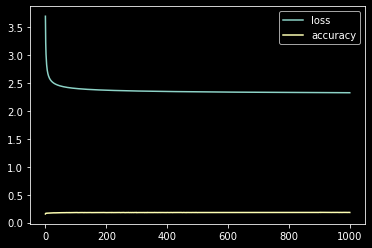

In [ ]:
pd.DataFrame(hist.history).plot()

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

es = EarlyStopping(patience=10, monitor='loss', restore_best_weights=True)
pb = TqdmCallback(verbose=1)

s2v.compile(
    optimizer=opt,
    loss=loss,
    metrics=['accuracy'],
)

epochs = 500

hist_2 = s2v.fit(
    x=(X, X_context),
    y=y, 
    epochs=epochs, 
    batch_size=1024, 
    callbacks=[es, pb],
    verbose=0)

In [ ]:
pd.DataFrame(hist_2.history).plot()